/var/folders/08/51ch_vwn57lgdw3v47gn9rjh0000gn/T/ipykernel_3187/906342607.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = pd.DataFrame({'A': A, 'B': B}, index=pd.date_range(start='2023-01-01', periods=1000, freq='H'))
/Users/mmcao/anaconda3/envs/tinyrag/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Performing Augmented Dickey-Fuller (ADF) Test:
ADF Test for A:
ADF Statistic: -0.9752263582977257
p-value: 0.7621923520778555
Critical Values:
	1%: -3.4370471695043037
	5%: -2.8644967585264784
	10%: -2.5683443301882956
Conclusion:
	The series is non-stationary.

ADF Test for B:
ADF Statistic: -1.4752297367309077
p-value: 0.5457273204015133
Critical Values:
	1%: -3.437054035425408
	5%: -2.8644997864059363
	10%: -2.5683459429326576
Conclusion:
	The series is non-stationary.


Cross-Correlation Analysis:
Maximum correlation occurs at lag -7
Maximum correlation value: 0.3673

Performing Granger Causality Test:
Granger Causality Test Results:
Lag 1:
  F-statistic: 0.0214
  p-value: 0.8838
  Conclusion: A does not Granger-cause B

Lag 2:
  F-statistic: 2.2152
  p-value: 0.1097
  Conclusion: A does not Granger-cause B

Lag 3:
  F-statistic: 4.0191
  p-value: 0.0074
  Conclusion: A Granger-causes B

Lag 4:
  F-statistic: 4.8246
  p-value: 0.0007
  Conclusion: A Granger-causes B

Lag 5:
  F-sta

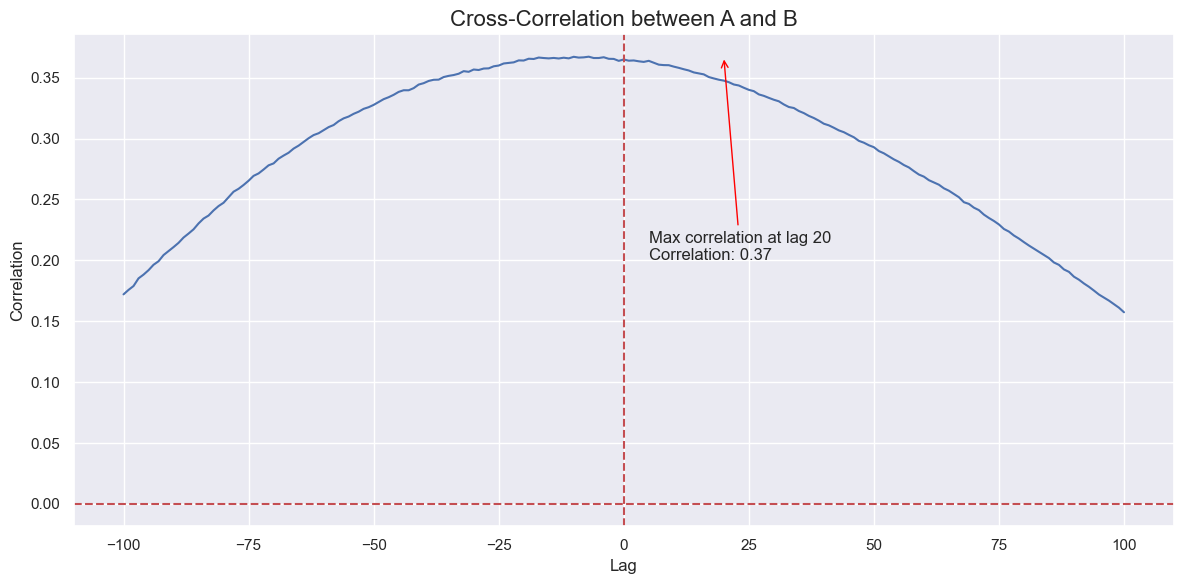

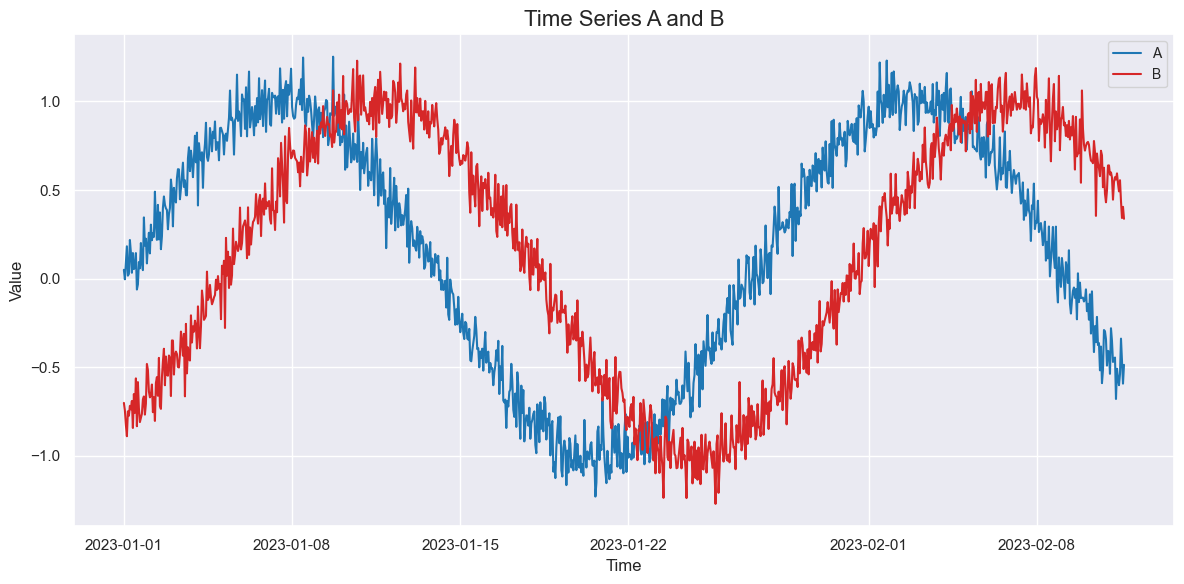

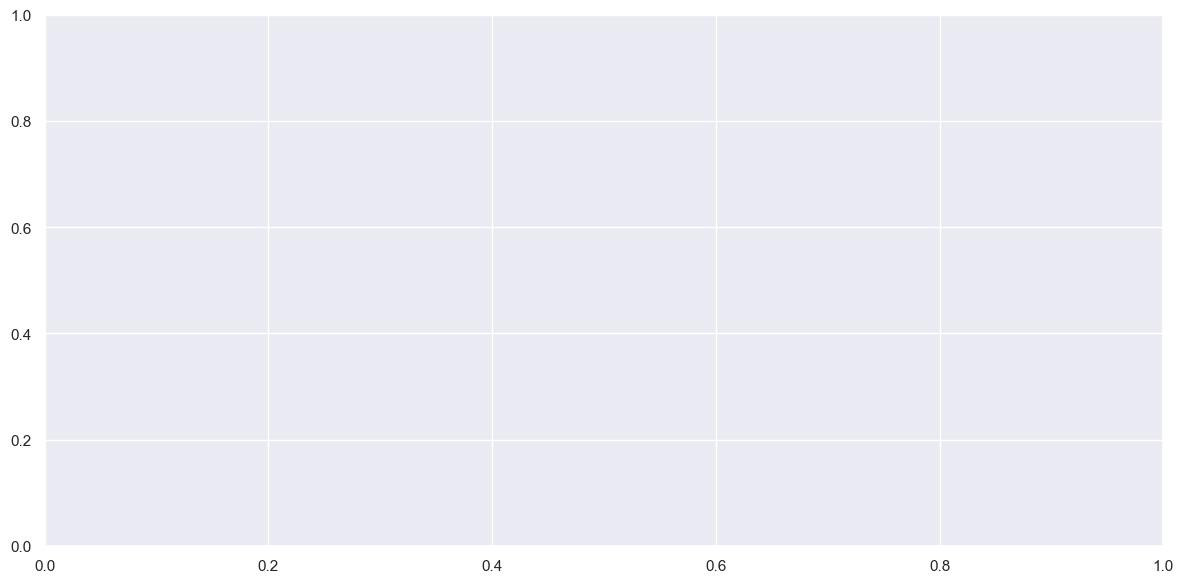

/Users/mmcao/anaconda3/envs/tinyrag/lib/python3.10/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf, adfuller, grangercausalitytests
from scipy import stats
import seaborn as sns
from matplotlib.animation import FuncAnimation

# 设置随机种子以确保结果可重现
np.random.seed(42)

# 生成示例数据
t = np.linspace(0, 100, 1000)
A = np.sin(0.1 * t) + 0.1 * np.random.randn(1000)
B = np.sin(0.1 * (t - 10)) + 0.1 * np.random.randn(1000)  # B滞后A 10个单位

# 创建DataFrame
df = pd.DataFrame({'A': A, 'B': B}, index=pd.date_range(start='2023-01-01', periods=1000, freq='H'))

# 1. 单位根检验（ADF检验）
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Test for {series.name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('Conclusion:')
    print('\tThe series is stationary.' if result[1] < 0.05 else '\tThe series is non-stationary.')
    print()

print("Performing Augmented Dickey-Fuller (ADF) Test:")
adf_test(df['A'])
adf_test(df['B'])

# 2. 交叉相关分析
lag_range = 100
ccf_result = ccf(df['A'], df['B'], adjusted=False)
lags = np.arange(-lag_range, lag_range + 1)
ccf_values = ccf_result[len(ccf_result)//2-lag_range:len(ccf_result)//2+lag_range+1]

max_lag = lags[np.argmax(np.abs(ccf_values))]
max_corr = ccf_values[np.argmax(np.abs(ccf_values))]

print("\nCross-Correlation Analysis:")
print(f"Maximum correlation occurs at lag {max_lag}")
print(f"Maximum correlation value: {max_corr:.4f}")

# 3. Granger因果检验
max_lag = 20  # 设置最大滞后期
print("\nPerforming Granger Causality Test:")
granger_result = grangercausalitytests(df[['A', 'B']], maxlag=max_lag, verbose=False)

# 提取并打印Granger因果检验的结果
print("Granger Causality Test Results:")
for lag, result in granger_result.items():
    f_test = result[0]['ssr_ftest']
    print(f"Lag {lag}:")
    print(f"  F-statistic: {f_test[0]:.4f}")
    print(f"  p-value: {f_test[1]:.4f}")
    print(f"  Conclusion: {'A Granger-causes B' if f_test[1] < 0.05 else 'A does not Granger-cause B'}")
    print()

# 4. 相关系数
correlation = df['A'].corr(df['B'])
print(f"\nPearson Correlation Coefficient: {correlation:.4f}")

# 5. 画图展示结果

# 设置Seaborn样式
sns.set_theme(style="darkgrid")

# 交叉相关图
plt.figure(figsize=(12, 6))
plt.plot(lags, ccf_values)
plt.axvline(x=0, color='r', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Cross-Correlation between A and B', fontsize=16)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.annotate(f'Max correlation at lag {max_lag}\nCorrelation: {max_corr:.2f}', 
             xy=(max_lag, max_corr), xytext=(5, 0.2),
             arrowprops=dict(arrowstyle="->", color='red'))
plt.tight_layout()
plt.show()

# 时间序列图
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['A'], label='A', color='#1f77b4')
plt.plot(df.index, df['B'], label='B', color='#d62728')
plt.title('Time Series A and B', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# 动态可视化函数
def create_animation():
    fig, ax = plt.subplots(figsize=(12, 6))

    def animate(i):
        ax.clear()
        shift = i - 50  # 从-50到50的偏移
        df_shifted = df.copy()
        df_shifted['A_shifted'] = df_shifted['A'].shift(shift)
        
        ax.plot(df_shifted.index, df_shifted['B'], label='B', color='#1f77b4')
        ax.plot(df_shifted.index, df_shifted['A_shifted'], label=f'A (shifted by {shift})', color='#d62728', alpha=0.7)
        
        ax.set_title(f'Time Series A and B (A shifted by {shift})', fontsize=16)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        ax.legend(fontsize=10)
        
        # 添加相关系数注释
        corr = df_shifted['A_shifted'].corr(df_shifted['B'])
        ax.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                    fontsize=10)

    anim = FuncAnimation(fig, animate, frames=101, interval=100, blit=False)
    plt.tight_layout()
    plt.show()

# 创建并显示动画
create_animation()